# Exploratory analysis of the HHL linear solver

## Implementation in `qiskit`

`qiskit` has an implementation of the hhl algorithm.
It can be imported using:

In [1]:
from qiskit.algorithms.linear_solvers.hhl import HHL

## Minimal example

We'll begin by importing a couple of dependencies.

In [2]:
import numpy as np
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.matrices.tridiagonal_toeplitz import TridiagonalToeplitz
from qiskit.quantum_info import Statevector

## Problem posing

We'll solve a simple linear system of the form:

$$
A \vec x = \vec b
$$

where:

$$
A =
\begin{bmatrix}
a & b \\
b & a
\end{bmatrix}
:
a = 1,
b = -\frac{1}{3}
$$

and

$$
\vec b = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
$$

This example is based on the [`qiskit` tutorials](https://qiskit.org/textbook/ch-applications/hhl_tutorial.html), which in turn is based on [this publication](https://arxiv.org/abs/2108.09004).

In [3]:
a = 1
b = -1/3
matrix = np.array([[a, b], [b, a]])
vector = np.array([1, 0])

### Classical solution

Keep in mind that during the encoding the vector will be normalized.
This means that the equivalent classical problem would be that of:

$$
A\vec x = \frac{\vec b}{\| \vec b\|} \equiv \hat b
$$

In [4]:
nvector = vector / np.linalg.norm(vector)
classical_solution = NumPyLinearSolver().solve(matrix, nvector)
print(classical_solution)

{   'circuit_results': None,
    'euclidean_norm': 1.1858541225631423,
    'observable': None,
    'state': array([1.125, 0.375])}


The solution is given by:

In [5]:
exact_solution = classical_solution.state
print(exact_solution)

[1.125 0.375]


We can check that the classical solution $\vec s$ is correct by evaluating ensuring that:

$$
A \vec s - \hat b = \vec 0
$$

In [6]:
assert np.max(np.matmul(matrix, classical_solution.state) - nvector) == 0.0

## HHL solution

The `HHL` method has a very similar interface to that of `NumPyLinearSolver`, but applied naively, it will return the circuit instead of the solution:

### Naive approach

In [7]:
naive_hhl_solution = HHL().solve(matrix, vector)
print(naive_hhl_solution.state)

      ┌───────────┐┌──────┐        ┌─────────┐
q0_0: ┤ circuit-7 ├┤2     ├────────┤2        ├
      └───────────┘│      │┌──────┐│         │
q1_0: ─────────────┤0 QPE ├┤1     ├┤0 QPE_dg ├
                   │      ││      ││         │
q1_1: ─────────────┤1     ├┤0 1/x ├┤1        ├
                   └──────┘│      │└─────────┘
q2_0: ─────────────────────┤2     ├───────────
                           └──────┘           


We can also print it (slightly) prettier:

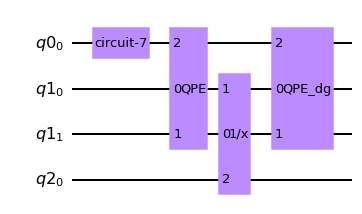

In [8]:
naive_hhl_solution.state.draw()

In [9]:
Statevector(naive_hhl_solution.state).data

array([ 4.33012702e-01-1.54922403e-16j, -4.33012702e-01+1.63716296e-16j,
        3.92869907e-17+2.47533443e-16j,  1.14620566e-17+1.10606299e-17j,
       -4.25332761e-17+1.39876065e-16j, -4.17197148e-17+3.96273765e-16j,
        2.14901449e-16-1.27796014e-17j, -2.48405393e-16-6.18208192e-18j,
        7.50000000e-01-9.71922214e-17j,  2.50000000e-01+1.54113871e-16j,
        1.45301041e-18-1.52703373e-16j, -1.61032576e-17+1.53359932e-17j,
        3.72797834e-17-1.29741245e-16j, -5.64974152e-17-4.00282492e-16j,
       -1.61771350e-16+3.67922086e-17j,  2.42657025e-16-2.55822216e-17j])

In order to peek into the solutions, we can proceed as follows:

In [10]:
''' Auxiliary function to extract the full solution as an array

Based on https://qiskit.org/textbook/ch-applications/hhl_tutorial.html
'''
def get_solution_as_array(qc, isreal=True):
    # Extract state as Statevector
    statevec = Statevector(qc.state).data
    
    # Extract the relevant information TODO: why is it so obscure?
    solvec = np.array([statevec[8], statevec[9]])

    # If we expect real values ...
    if isreal: # ... get rid of the imaginary parts
        solvec = np.real(solvec)

    # Fix possible rescalings made by the circuit
    solvecrenorm = qc.euclidean_norm * solvec / np.linalg.norm(solvec)

    return solvecrenorm


In [11]:
print(get_solution_as_array(naive_hhl_solution))

[1.125 0.375]


### Using `TridiagonalToeplitz`

It is advisable to encode the problem using a `TridiagonalToeplitz` matrix instead.
The equivalent matrix for our problem will be:

$$
A =
\begin{bmatrix}
a & b & 0 & 0 \\
b & a & b & 0 \\
0 & b & a & b \\
0 & 0 & b & a
\end{bmatrix}
$$

Keep in mind that for problems larger than $2 \times 2$ the results of using `TridiagonalToeplitz` would be approximate.

In [12]:
tridi_matrix = TridiagonalToeplitz(num_state_qubits=1, main_diag=a, off_diag=b)
tridi_solution = HHL().solve(tridi_matrix, vector)
print(get_solution_as_array(tridi_solution))

[1.125 0.375]


## Observables

In real quantum computers, we cannot know the full state vector; we have to compute observables instead.

So far, the only implemented operators for `linear_solvers` are `AbsoluteAverage` and `MatrixFunctional`.
As usual, we'll need to import them to begin with.

In [13]:
from qiskit.algorithms.linear_solvers.observables import AbsoluteAverage, MatrixFunctional

The `AbsoluteAverage` operator returns:

$$
{\tt AbsoluteAverage}(\vec x) = \| \frac{1}{N} \sum_{i=1}^N x_i \|
$$

In [14]:
observable = AbsoluteAverage()
average_hhl_solution = HHL().solve(matrix, vector, observable)

We can compare the result with the exact value:

In [15]:
print("Average with HHL :", average_hhl_solution.observable)
print("Average (exact)  :", np.mean(exact_solution))

Average with HHL : 0.7499999999999993
Average (exact)  : 0.75


The `MatrixFunctional` operator contains a tridiagonal matrix $B$, and returns:

$$
{\tt MatrixFunctional} (\vec x; a, b) = \bra{x} B(a, b) \ket{x} = \vec x^T B(a, b) \vec x 
$$

where:

$$
B(a,b) = 
\begin{bmatrix}
a & b & 0 & 0 & \dots \\
b & a & b & 0 & \dots \\
0 & b & a & b & \dots \\
0 & 0 & b & a & \dots \\
\vdots & \vdots & \vdots & \vdots & \ddots

\end{bmatrix}
$$

Note that, because $B$ is tridiagonal, this is not a general operator.

In [16]:
observable = MatrixFunctional(a, b)
mf_hhl_solution = HHL().solve(matrix, vector, observable)

In [17]:
print("Matrix functional with HHL :", mf_hhl_solution.observable)
print("Matrix functional (exact)  :", np.matmul(np.transpose(exact_solution), np.matmul(matrix, exact_solution)))

Matrix functional with HHL : 1.124999999999999
Matrix functional (exact)  : 1.125


## Generic observables

We'll eventually need a full solution of the original problem.
The implemented observables, which calculate things such as the arithmetic average, are not completely satisfying in this sense.

In this section we'll try to deviate from the recommended use of `HHL().solve()` with a generic observable as an input.

In order to do this, we'll need to import some [operators](https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html):

In [18]:
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import (
    Z,
    I,
    StateFn,
    OperatorBase,
    TensoredOp,
    ExpectationBase,
    CircuitSampler,
    ListOp,
    ExpectationFactory,
)

We'll construct the $0$ and $1$ operators from the identity operator and the $\sigma_z$ Pauli matrix.

Their most important property is that, for:

$$
\ket{\psi} = x_0 \ket{0} + x_1 \ket{1}
$$

they verify:

$$
\bra{\psi} 0 \ket{\psi} = \| x_0 \|^2 \\
\bra{\psi} 1 \ket{\psi} = \| x_1 \|^2
$$

Or, equivalently:

$$
0 = \ket{0} \bra{0} \\
1 = \ket{1} \bra{1}
$$

In [19]:
zero_op = (I + Z) / 2 # <x|0|x> returns the square amplitude associated to |0>
one_op = (I - Z) / 2 # <x|1|x> returns the square amplitude associated to |1>

Operators can be composed.
Tensor product is particularly useful for this.
For instance:

$$
1 \otimes 0 = 10
$$

Where the operator $10$ verifies:

$$
\bra{\psi} 10 \ket{\psi} = \| x_{10} \|^2
$$

for a 2-qubit vector.

In our example, we want to extract the amplitudes corresponding to $\ket{1000}$ and $\ket{1001}$.
We can build these by:

In [20]:
ampsq0001 = (TensoredOp(3*[zero_op]) ^ one_op) # Square amplitude associated to |1000>
ampsq1001 = (one_op ^ TensoredOp(2*[zero_op]) ^ one_op) # Square amplitude associated to |1001>

This approach fails due to the fact that $0$ and $1$ are fundamentally non-unitary.


Why?
Think of their matrix representation: they are zeros everywhere but in a single element.
So they are not invertible.

In [21]:
# observable = ampsq0001
# hhl_solution = HHL().solve(matrix, vector, observable, observable_circuit=observable)

## Brute force approach

Another possibility is extracting the circuit and proceed from there using first principles.

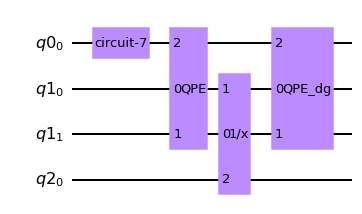

In [22]:
qc = naive_hhl_solution.state
qc.draw()

We'll use `transpile` to rewrite our circuit exclusively in terms of basic gates:

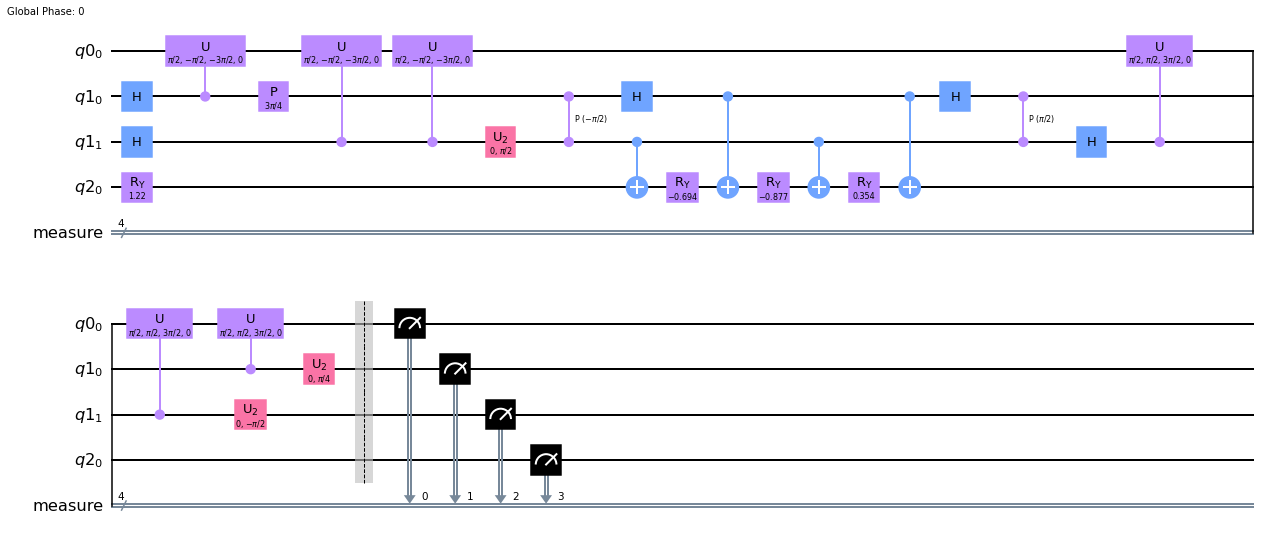

In [23]:
from qiskit import Aer, transpile

sim = Aer.get_backend('aer_simulator')

circ = transpile(qc, sim)
circ.measure_active()
circ.draw()

Now we can simulate the circuit.

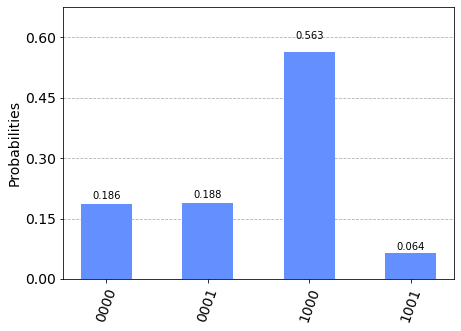

In [24]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

shots = 100000
result = sim.run(circ, shots=shots).result()
counts = result.get_counts()

plot_histogram(counts)

The solution is encoded in the coefficients of $\ket{1000}$ and $\ket{1001}$.
We can extract the absolute value of their coefficients by taking the square root of their measured probabilities.

In [25]:
""" Auxiliary function. Reads the probability of a given state"""
def get_prob(key):
    return counts.get(key) / shots

probs = [get_prob("1000"), # These are our only probabilities of interest
         get_prob("1001")]

unsignedcoefs = np.sqrt(probs)

print("Probabilities : ", probs)
print("Coefficients  : ", unsignedcoefs)

Probabilities :  [0.56283, 0.0636]
Coefficients  :  [0.75021997 0.2521904 ]


The circuit introduces a renormalization, but the ratio between both coordinates should remain constant:

In [26]:
print(unsignedcoefs[0] / unsignedcoefs[1])
print(exact_solution[0] / exact_solution[1])

2.974815675279191
3.0000000000000004
